In [3]:
import cv2
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# from google.colab import drive

In [4]:
# # Mount the Google Drive
# drive.mount('/content/drive',force_remount=True)

# <b> Preprocessing : 

In [5]:
folder_path = 'dataset-doctor-bills'
forged_folder = os.path.join(folder_path, 'forged')
gen_folder = os.path.join(folder_path, 'genuine')

In [6]:
# Set the resize dimensions
resize_dims = (2048, 2048)

In [7]:
forged_augmented_folder = os.path.join(folder_path, 'forged_augmented')
genuine_augmented_folder = os.path.join(folder_path, 'genuine_augmented')

# Ensure output directories exist
os.makedirs(forged_augmented_folder, exist_ok=True)
os.makedirs(genuine_augmented_folder, exist_ok=True)


In [8]:
datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize the images to [0, 1] range
    rotation_range=30,  # Rotate the image by a max of 30 degrees
    width_shift_range=0.2,  # Randomly shift the image horizontally (20%)
    height_shift_range=0.2,  # Randomly shift the image vertically (20%)
    shear_range=0.2,  # Shearing transformations
    zoom_range=0.2,  # Zoom in/out by 20%
    horizontal_flip=True,  # Randomly flip the image horizontally
    fill_mode='nearest'  # Fill the empty pixels after the transformation
)

In [12]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
def augment_images(input_folder, output_folder, prefix):
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".tif"):  # Add other formats if needed
            img_path = os.path.join(input_folder, filename)
            img = load_img(img_path, target_size=resize_dims)
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for the generator

            # Create a batch of augmented images
            i = 0
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_folder, 
                                      save_prefix=prefix, save_format='jpg'):
                i += 1
                if i >= 5:  # Save 5 augmented images per original image
                    break  # Stop after creating 5 augmented images

# Augment images in the 'forged' folder and save to 'forged_augmented'
augment_images(forged_folder, forged_augmented_folder, prefix='forged_aug')

# Augment images in the 'genuine' folder and save to 'genuine_augmented'
augment_images(gen_folder, genuine_augmented_folder, prefix='genuine_aug')

In [14]:
import os
import random

# Path to the genuine folder
gen_folder = 'dataset-doctor-bills/Final_Data/Final_Genuine'

# Get a list of all image files in the genuine folder
all_images = [filename for filename in os.listdir(gen_folder) if filename.endswith(".jpg") or filename.endswith(".png")]

# Check if there are exactly 500 images in the folder
if len(all_images) >= 500:
    # Randomly select between 250 and 260 images to delete
    num_images_to_delete = random.randint(250, 260)

    # Randomly select the images to delete from the 500 images
    images_to_delete = random.sample(all_images, num_images_to_delete)

    # Delete the selected images
    for image in images_to_delete:
        image_path = os.path.join(gen_folder, image)
        os.remove(image_path)

    print(f"Deleted {num_images_to_delete} images from the genuine folder.")
else:
    print(f"Expected 500 images, but found {len(all_images)} images.")


Deleted 253 images from the genuine folder.


# <b> CNN Model :

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generator with 70-30 train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)  # Normalize images
base_directory = '/content/drive/My Drive/Final_Data'
# Load training set (70%)
train_generator = datagen.flow_from_directory(
    base_directory,
    target_size=(224, 224),  # Resize images if needed
    batch_size=32,
    class_mode='categorical',  # Use 'binary' if you have 2 classes
    subset='training'
)

# Load test set (30%)
test_generator = datagen.flow_from_directory(
    base_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 156 images belonging to 2 classes.
Found 66 images belonging to 2 classes.


In [15]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='sigmoid')  # For multi-class classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use binary_crossentropy for binary classification
              metrics=['accuracy'])


In [16]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.4972 - loss: 1.0297 - val_accuracy: 0.8182 - val_loss: 0.4869
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8298 - loss: 0.5250 - val_accuracy: 0.8182 - val_loss: 0.5064
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8183 - loss: 0.4957 - val_accuracy: 0.8182 - val_loss: 0.4755
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8109 - loss: 0.4855 - val_accuracy: 0.8182 - val_loss: 0.4764
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7980 - loss: 0.4900 - val_accuracy: 0.8182 - val_loss: 0.4810
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8027 - loss: 0.4763 - val_accuracy: 0.8182 - val_loss: 0.4838
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7796 - loss: 0.4725 - val_accuracy: 0.8182 - val_loss: 0.4913
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8271 - loss: 0.4130 - val_accuracy: 0.8182 - val_loss: 0.5427
Epoch 9/

In [17]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6309 - loss: 2.6382
Test accuracy: 0.6212121248245239


1.   Above it is seen that above after 17th ep. Overfitting is seen nd
similarly acc. is dropped by a lot!.
2.   Last ep i.e 20th accu is 100% and test acc is 66% hence model is performing overfitting.

In [18]:
model.save('/content/drive/MyDrive/cnn_model20.h5')

# <b> Apply Regularisation

##DropOut :

In [19]:
from tensorflow.keras import regularizers

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Add dropout to prevent overfitting
    layers.Dropout(0.5),

    layers.Flatten(),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # L2 regularization
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.7011 - loss: 1.2915 - val_accuracy: 0.8182 - val_loss: 0.6481
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8109 - loss: 0.6915 - val_accuracy: 0.8182 - val_loss: 0.7051
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8005 - loss: 0.7172 - val_accuracy: 0.8182 - val_loss: 0.6779
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8184 - loss: 0.6865 - val_accuracy: 0.8182 - val_loss: 0.6736
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8032 - loss: 0.6916 - val_accuracy: 0.8182 - val_loss: 0.6528
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7999 - loss: 0.6606 - val_accuracy: 0.8182 - val_loss: 0.6466
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8012 - loss: 0.6710 - val_accuracy: 0.8182 - val_loss: 0.6499
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8227 - loss: 0.6220 - val_accuracy: 0.8182 - val_loss: 0.6247
Epoch 9/

In [21]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8153 - loss: 0.6318
Test accuracy: 0.8181818127632141


In [22]:
model.save('/content/drive/MyDrive/cnn_model50_DropOutES.h5')


#Reduce LR on plateau : (Reduce Learning Rate on Plateau.)

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8195 - loss: 0.5659 - val_accuracy: 0.8182 - val_loss: 0.6425 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8313 - loss: 0.5438 - val_accuracy: 0.8182 - val_loss: 0.6307 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8070 - loss: 0.5099 - val_accuracy: 0.8182 - val_loss: 0.6632 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8390 - loss: 0.4199 - val_accuracy: 0.8030 - val_loss: 0.7754 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8699 - loss: 0.3888 - val_accuracy: 0.8030 - val_loss: 0.9057 - learning_rate: 0.0010


In [24]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7919 - loss: 0.6683
Test accuracy: 0.8181818127632141


In [26]:
model.save('/content/drive/MyDrive/cnn_model50_RLR-ES.h5')

In [ ]:
# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),

#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dense(train_generator.num_classes, activation='softmax')
# ])


## RESNET-50


In [27]:
# Define the base directory
b_dir = '/content/drive/My Drive/Final_Data'
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)  # Normalize images


# Training data generator
train_generator = train_datagen.flow_from_directory(
    b_dir,
    target_size=(224, 224),  # ResNet50 input size
    batch_size=32,
    class_mode='binary',     # Binary classification
    subset='training',
    shuffle=True)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    b_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False)


Found 156 images belonging to 2 classes.
Found 66 images belonging to 2 classes.


In [28]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # For binary classification
])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [29]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [30]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.5791 - loss: 0.7030 - precision: 0.8728 - recall: 0.5473 - val_accuracy: 0.8182 - val_loss: 0.5236 - val_precision: 0.8182 - val_recall: 1.0000
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7111 - loss: 0.5432 - precision: 0.7989 - recall: 0.8481 - val_accuracy: 0.8182 - val_loss: 0.4733 - val_precision: 0.8182 - val_recall: 1.0000
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7684 - loss: 0.5534 - precision: 0.7813 - recall: 0.9723 - val_accuracy: 0.8182 - val_loss: 0.4912 - val_precision: 0.8182 - val_recall: 1.0000
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8010 - loss: 0.5689 - precision: 0.8103 - recall: 0.9834 - val_accuracy: 0.8182 - val_loss: 0.5016 - val_precision: 0.8182 - val_recall: 1.0000
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8129 - loss: 0.5959 - precision: 0.8129 - recall: 1.0000 - val_accuracy: 0.8182 - val_loss: 0.4948 - val_precision

In [31]:
# Evaluate on validation data
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7685 - loss: 0.5460 - precision: 0.7685 - recall: 1.0000
Validation Accuracy: 0.8181818127632141
Validation Precision: 0.8181818127632141
Validation Recall: 1.0


In [32]:
train_loss, train_accuracy, train_precision, train_recall = model.evaluate(train_generator)
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Precision: {train_precision}")
print(f"Training Recall: {train_recall}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8027 - loss: 0.4906 - precision: 0.8027 - recall: 1.0000
Training Accuracy: 0.807692289352417
Training Precision: 0.807692289352417
Training Recall: 1.0


In [33]:
model.save('/content/drive/MyDrive/resnet_model50.h5')


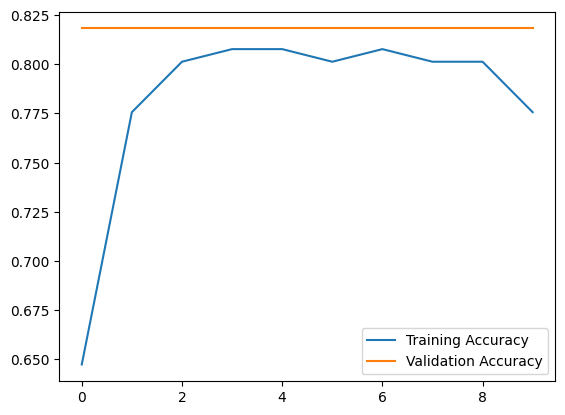

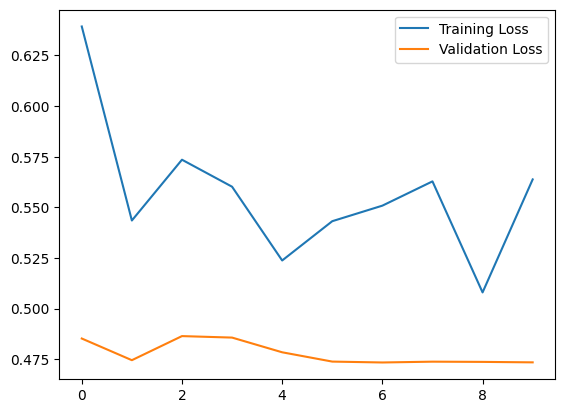

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [ ]:
train_class_counts = train_generator.classes
print(np.bincount(train_class_counts))
print(train_generator.class_indices)


[ 30 126]
{'Final_Forged': 0, 'Final_Genuine': 1}


Since, The forged class was not augmented there is a heavy imbalance in model

*   List item
*   List item

training. Now , two methods to subsidise the effect of this imbalance will be taken:
1. Giving class weights to minority class
2. Aggressive augmentation of the forged class


## Approach 1: Giving class weights to minority class

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

class_weights = {0: len(train_generator.classes)/15, 1: len(train_generator.classes)/258}


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Training the model with class weights and early stopping
history_weighted = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping]
)




Epoch 1/20


KeyboardInterrupt: 

In [ ]:
# Evaluate the model with class weights
val_loss_weighted, val_accuracy_weighted, val_precision_weighted, val_recall_weighted = model.evaluate(validation_generator)
print(f"Class Weighting - Validation Accuracy: {val_accuracy_weighted}")
print(f"Class Weighting - Validation Precision: {val_precision_weighted}")
print(f"Class Weighting - Validation Recall: {val_recall_weighted}")

In [ ]:


early_stopping_2 = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# Training the model with class weights and early stopping
history_weighted_2 = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping_2]
)




## Approach 2: Data Augmentation for Minority Class

In [ ]:
genuine_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

# Data augmentation for forged classes
forged_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

# Generator for genuine images
genuine_generator = genuine_datagen.flow_from_directory(
    '/content/drive/My Drive/Bajaj-HackRX/datasets/Final_data/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Generator for forged images (from both subfolders)
forged_generator_type01 = forged_datagen.flow_from_directory(
    '/content/drive/My Drive/Bajaj-HackRX/datasets/Final_data/preprocessed_forged/type01',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

forged_generator_type02 = forged_datagen.flow_from_directory(
    '/content/drive/My Drive/Bajaj-HackRX/datasets/Final_data/preprocessed_forged/type02',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)


In [ ]:
import numpy as np

def balanced_generator(genuine_gen, forged_gen1, forged_gen2, batch_size=32):
    while True:
        genuine_batch = next(genuine_gen)
        forged_batch1 = next(forged_gen1)
        forged_batch2 = next(forged_gen2)

        # Combine the batches
        combined_images = np.concatenate([genuine_batch[0], forged_batch1[0], forged_batch2[0]], axis=0)
        combined_labels = np.concatenate([genuine_batch[1], forged_batch1[1], forged_batch2[1]], axis=0)

        # Shuffle the combined data
        indices = np.arange(combined_images.shape[0])
        np.random.shuffle(indices)

        yield combined_images[indices], combined_labels[indices]

# Using balanced generator for training
balanced_train_generator = balanced_generator(genuine_generator, forged_generator_type01, forged_generator_type02)

# Training the model using the combined balanced generator
history = model.fit(
    balanced_train_generator,
    steps_per_epoch=len(genuine_generator),
    epochs=20,
    validation_data=validation_generator
)


NameError: name 'genuine_generator' is not defined

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Function to draw bounding box on an image
def draw_bounding_box(image, box_coordinates):
    x, y, w, h = box_coordinates  # Coordinates predicted by ResNet
    x, y, w, h = int(x), int(y), int(w), int(h)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red box
    return image

# Function to preprocess the image before prediction
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to process images and predict forgery bounding boxes using ResNet
def process_images(input_dir, output_dir, model):
    for root, dirs, files in os.walk(input_dir):
        # Create corresponding output directories
        rel_path = os.path.relpath(root, input_dir)
        output_subdir = os.path.join(output_dir, rel_path)
        os.makedirs(output_subdir, exist_ok=True)

        for file in files:
            if file.endswith(('.tif', '.png', '.jpg', '.jpeg')):
                input_image_path = os.path.join(root, file)

                # Modify filename by appending 'p' before the extension
                file_name, file_ext = os.path.splitext(file)
                new_file_name = f"{file_name}p{file_ext}"

                output_image_path = os.path.join(output_subdir, new_file_name)

                # Preprocess the image
                preprocessed_image = preprocess_image(input_image_path)
                if preprocessed_image is not None:
                    # Predict the bounding box using ResNet model
                    box_coordinates = model.predict(preprocessed_image)
                    box_coordinates = box_coordinates[0]  # Since we have batch dimension

                    # Load the original image for drawing
                    original_image = cv2.imread(input_image_path)
                    original_image = cv2.resize(original_image, (224, 224))

                    # Draw the bounding box on the image
                    image_with_box = draw_bounding_box(original_image, box_coordinates)

                    # Save the processed image with the bounding box
                    cv2.imwrite(output_image_path, image_with_box)
                    print(f"Saved preprocessed image with bounding box: {output_image_path}")


In [ ]:
# from tensorflow.keras.models import load_model

# # Load the model and print the architecture to check input details
# resnet_model = load_model('/content/drive/MyDrive/resnet_model50.h5')

# # Print model summary
# resnet_model.summary()


In [ ]:
process_images(forged_dir, preprocessed_forged_dir, '/content/drive/MyDrive/resnet_model50.h5')